# DEq - A Card Quality Metric

## Introduction

This post is intended to give a technical description of the modeling underpinning DEq, my card quality metric. For now, the official implementation of DEq and a distinguished cut of data can be found in my Google Sheet [here](https://docs.google.com/spreadsheets/d/1n1pfrb5q_2ICYk-vfF3Uwo8t61DJU-5T_DFe0dwk8DY/edit?usp=sharing). 

The motivating idea behind DEq is this: when we pick a card, we want to choose the card that adds the most value to our pool. One of the ways
we inform this decision is by looking at metrics, which tend to be one-dimensional (i.e., numerical rankings) and are necessarily aggregated over some diverse set of situations
which may affect the interpretation of the data. Finally, thanks to the availability of daily data on 17Lands.com and the lack of alternatives, 
a timely and usable card metric must be assembled out of the data points available on that site. DEq is intended to model the desired value under the
given constraints.

In particular, we will ask "For a given card $c$, what is the average marginal win rate attributable to choosing the card relative to picking it into the trash". The last part of that
condition might seem a bit strange. Why not "compared to the next alternative"? The reason is that the alternative depends on the context in which the card was observed to be chosen, 
whereas when we are choosing between two cards, we want a consistent baseline that enables us to make that comparison. When cards were observed to be chosen highly, a greater cost in fresh packs
was paid compared to cards that were chosen later, and the core idea of DEq is to account for that difference, by crediting that cost, as measured by ATA, back to the imputed win rate.

The base formula for DEq is as follows, which I will then explain and derive in detail for those who have the appetite:

$$
\text{DEq Base} = \text{GP %}(c) \cdot \left( \text{GP WR}(c) - \mu + 3\% \cdot(1 - (\text{ATA}(c) - 1) / 14 )^2 \right).
$$

I then further apply some relatively minor adjustments which I will detail below and are provisional anyway. DEq Base is perfectly suitable on its own as a card quality metric. 

## Pick Equity

Let 

$$\mu = P[\text{W}]$$ 

be the theoretical mean game win rate for a given player cohort (e.g. me, you, or 17Lands "Top" players) for a metagame (e.g. a particular set on a particular day for a particular rank), and let 

$$\mu_k = P[\text{W} | N_k]$$ 

be the probability of winning conditioned on a "null pick" $N_k$, meaning, picking a card straight into the trash, or replacing it with a basic land, for one $k$-th pick in one pack (i.e. averaged over the three packs). Then let 

$$ r_k = \mu - \mu_k $$

be the "pick equity" of a $k$-th pick, that is, the marginal win rate attributable to making that pick, on average. When you choose a card with a $k$-th pick, on average, you are giving up $r_k$ of winrate in exchange for 
adding that particular card to your pool.



A proper estimate of $r_k$ is a piece of analysis that I intend to do thoroughly down the road, but for now I am relying on estimates based on previous analysis and a bit of eye test on the final results. I've found that a quadratic fit with P1 being worth 3% gives good results. Note that DEq is most useful in pack one, where your early picks are generally more valuable.

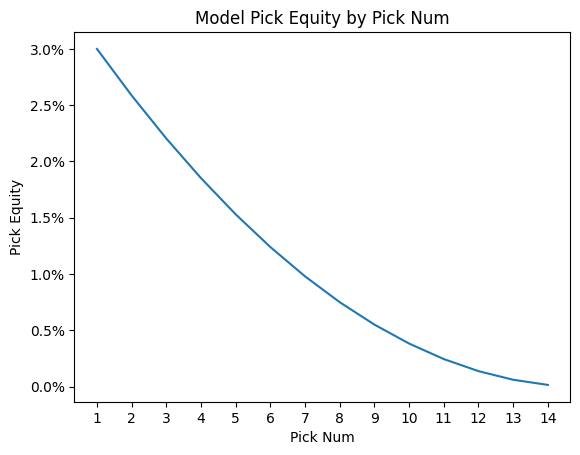

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

_, ax = plt.subplots()
x = np.arange(1, 15)
y = 0.03 * (1 - (x - 1) / 14) ** 2
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.plot(x, y)
ax.set_title("Model Pick Equity by Pick Num")
ax.set_ylabel("Pick Equity")
ax.set_xlabel("Pick Num")
ax.set_xticks(x)
plt.show()

In practice, we apply this model to the observed ATA (average taken at), since that is the number we have available. While there is a bit of convexity, this shouldn't trouble us too much. For a given card, in a given metagame, we identify this quantity as $r_{\text{ATA}(c)}.$

## DEq Base

We're going to get technical because it will allow us to specify exactly the assumptions that create bias in the final model. The notation is a bit complicated, and could be improved, but sometimes that's just the way it is. The final formula is relatively intuitive so you can skip to that. The essence of the below is that DEq is GP WR plus Pick Equity modified by GP %. We will have to define a bunch of events and rearrange some conditional probabilities to get there. 

Recall that $P$ represents a particular player/metagame probability model, and a conditional like $P[X| A]$ effectively takes a weighted average of $X$ restricted to the (theoretical) observations of $A$ within that same model. $P$ is "omniscient" in that it gives the true rate of outcomes all possible events. Finally, $P$ is a measure on "pick events", that is, observations of individual draft picks coupled with the resulting outcome. 


Given a card $c$, let $C$ be the set of draft pick events $\omega$ where $c$ was selected.

Now when we define our own probability space, we can make the event space as detailed as we like, so we couple the elements $\omega$ with all the information needed to construct counterfactual scenarios, and we will rely on $P$ to average them correctly. So let $\tilde{W}$ represent the counterfactual outcome under the null pick, and let

$$
q(c) = \frac{P[W(\omega) - \tilde{W}(\omega), \omega \in C]}{P[C]}.
$$

This is the formal expression of our idea about marginal win rate. We properly ask, at the operative moment, "What happens if we don't take the card instead?" 
So $q(c)$ is what I call the "draft equity" of $c$, and $DEq$ will be the metric estimating $q$. 

It will be more convenient to express this using the null pick notation above, so we "split out" the counterfactual outcomes to new elements $\omega$ to create events $N_C$ representing the same scenario up to the pick event, which is then replaced with the null pick and followed to the counterfactual outcome. Then

$$
q(c) = P[W | C] - P[W | N_C].
$$

$N_C$ may have zero measure under $P$, but we can just stipulate that events are weighted according to $C$ in the conditional measure and that should handle it.


Now the available metric that most nearly estimates $P[W | C]$ is GP WR, "games-played win rate", under the further condition that $c$ is played in our deck. Let $D = D(\omega)$ be the event that the card resulting from the specific pick event $\omega$ is played in the deck, and write

$$
\begin{align}
P[W | C] &= P[DW | C] + P[D^c W | C] \\
&= P[ D | C] \cdot P[ W | C, D]  + (1 - P[D]) \cdot P[ W | C, D^c],\\
\end{align}
$$

Now

$$
\begin{align}
q(c) = &P[D | C] \cdot (P[W | C, D] - P[W | N_C]) \\  
    &+ (1 - P[D | C]) \cdot (P[W | C, D^c] - P[W | N_C ]).
\end{align}
$$

To break this down we need some assumptions, which we will write down. 

 * **Assumption 1**: The quality (winrate) of $\omega \in N_C$ is independent of the card $c$, and only depends on the pick equity lost to the null pick. We should have good reason to believe this is not the case. We will look at a first attempt to adjust for the bias caused by this assumption in the next section.

 * **Assumption 2**: The quality of $\omega \in C \cap D^c$ is independent of $c$, and depends on the pick equity given up by not playing $c$. Again, this shouldn't be strictly true. We can examine the effect of this assumption by analyzing the as-picked win rate, which is available in the public data sets.
 
For fixed $k$, let $C_k \subset C$ be those k-th picks where $c$ was chosen, and using assumption 1 we have

$$
\begin{align}
P[W | N_{C_k}] &= \frac{P[W, C_k| N_k]}{P[C_k| N_k]} \\
    &= \frac{P[W | N_k] P[C_k | N_k ]}{P[C_k | N_k]} \\
    &= P[W | N_k],
\end{align}
$$

Therefore,

$$
\begin{align}
P[W | N_C] &= \frac{\sum_k P[C_k] \cdot P[ W | N_C, C_k]}{P[C]} \\
&= \frac{\sum_k P[C_k] \cdot P[ W | N_k]}{P[C]} \\ 
&= \frac{\sum_k P[C_k]\mu_k }{P[C]}  \\
&\sim \mu_{\sum_k P[k C_k| C]} \\
&= \mu_{\text{ATA}(c)},
\end{align}
$$

Jensen's inequality standing in for the $\sim$, which should be de minimis and is an assumed curve anyway. By the same calculation, $P[W | C, D^c] = \mu_{\text{ATA}(c)}$ given assumption 2 and the second term of $q(c)$ is zero.

Now, by design, we have estimators $\text{GP %}(c)$ for $P[D | C]$, and $\text{GP WR(c)}$ for $P[W | C, D]$, along with $\text{ATA}(c)$ for $P[k C_k | C]$. There should be no problems there, except to note that in general 17Lands stats come with a particular distribution of player preference and metagame sample, and we should keep in mind how that variation affects the representation of our particular situation. To start with, I recommend taking the "Top" player sample and the narrowest practical range of dates with a decent sample size. We'll look at one attempt to account for some of the remaining misrepresentation bias below.


Performing the substitutions, our formula is 

$$
\begin{align}
\text{DEq Base}(c) &= P[D | C] \cdot (P[W | C, D] - P[W | N_C]) \\
 &= \text{GP %}(c) \cdot \left( \text{GP WR}(c) - \mu_{\text{ATA}(c)}\right) \\
 &= \text{GP %}(c) \cdot \left( \text{GP WR}(c) - \mu + 3\% \cdot(1 - (\text{ATA}(c) - 1) / 14 )^2 \right).
 \end{align}
$$

This is the base formula I use in practice, so I call this quantity "DEq Base", and apply a few adjustments to provide the final estimate of DEq.

## Bias Adjustment

In general, $\tilde{W}$ is not independent of $c$. Rather than put forward a theory, I simply want to document how I currently handle this adjustment, which is not based on any analysis. The idea is that the marginal value atttributable to a given choice includes the effects that that choice has on deck composition down the road, but not the quality of deck composition present at the time of the pick (since those cards are present in the evaluation $\tilde{W}$). By analogy I extend this assumption to the other two packs as well: A fifth pick gets discounted for the value provided by early picks in other packs, on the theory that early picks set the tone for future early picks and future late picks, but not vice versa. Like I said, it's highly heuristic.

We want to adjust the DEq attributable to a pick for the excess DEq likely to be added to the pool up the ATA of the given card given the characteristics of the card, specifically which archetypes the card belongs to. Systematically, using the card attributes available on 17Lands, the straightforward thing to do is to use the color of the card as a proxy for archetype. Certainly there are more nuanced ways to approach this. The DEq attributable to an archetype should be largely inferrable from GP WR since we can generally expect people to be taking picks at their ATA on average regardless of archetype. Again, heuristic. The formula for bias adjustment as of today (Jan. 14, 2025) looks like this:

$$
\text{Bias Adj}(c) = \left(\frac{r_{\text{ATA}(c)}}{3\%}-1\right) \cdot \left(\text{GP WR}(\text{color(c)}) - \mu\right).
$$

For two-color gold cards, I use 50% of the marginal win rate of the gold cards in the set, and 25% each of the marginal win rates of the individual colors. The general idea is that a highly picked card gets full credit for the overperformance of its color, and a lower picked one gets a penalty of up to the full marginal win rate of its archetype. This value is added to DEq Base. In general, the effect of this adjustment is marginal, and I expect future tuning of the parameter will have a marginal effect as well, although I still want to fully explore the question. To get a sense of the impact, I'm including a graph generated from my [P1 Substitution Analysis](p1-strategy). This shows a model of the effect of choosing P1P1 based on different metrics by substituting the results of a given draft with one where the card pointed to by the metric was chosen instead. Let me show a couple graphs then explain my interpretation. If you're just running this notebook yourself for the first time, be forewarned that running this cell this will occupy your CPU for at least an hour.


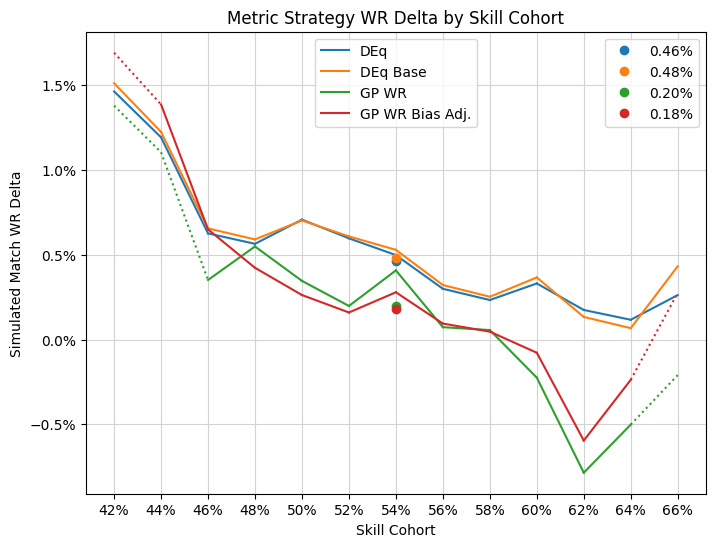

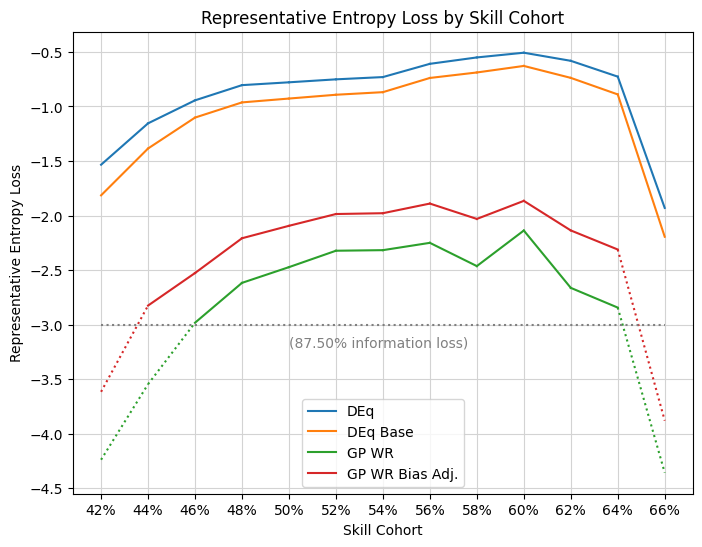

In [1]:
from deq.p1_strategy import all_metrics_analysis
from deq.plot import p1_line_plot

metrics = ["deq", "deq_base", "gp_wr", "gp_wr_bias_adj"]
res = all_metrics_analysis(metrics=["deq", "deq_base", "gp_wr", "gp_wr_bias_adj"])
p1_line_plot(res, metrics=metrics, mode="wr_delta")
p1_line_plot(res, metrics=metrics, mode="entropy_loss")

The first graph shows the simulated marginal effect on win rate of choosing the card in the pack with the highest value in each metric, respectively, for each p1p1 in 2.27
million drafts covering the last three years of major releases.
The interpretation is that if you used DEq (as calculated at the end of the format) to make all of your first picks, and made the rest of your choices according to your normal patterns, the average player's rate would increase by 0.46%, and 0.48% when using DEq Base. For some cuts where changes in the metagame are more relevant and GP WR by itself does worse, DEq does a bit better than DEq Base. So there is not a compelling argument either way in the win rate analysis to use the bias adjustment.

The second chart shows the entropy (information) lost by the substitution of picks by the analysis. What the chart shows is that the bias-adjusted version more closely emulates the actual picks made by players, which I think is valuable.

So overall, the effect of the bias adjustment is marginal, both in terms of the magnitude of the modifier and in terms of the effect when applying it as a strategy. I intend to look into this more deeply regardless.

By the way, if this is your first time seeing this analysis, note the significant
effect on win rate and representativeness that we get from adding pick equity to the base win rate. This is just the effect of making one pick differently; in real life you get to use DEq to inform all of your picks! I suspect it should be reasonable
to pick up 2% or more of win rate with an informed strategy.

## Metagame Adjustment

In practice, the data available to us is drawn from a different metagame than the one we wish to apply it to. Most applicably, the data on 17Lands.com is drawn from some set of days (which we can control) prior to the current date, the date on which we are intending to make good draft picks. The metagame evolves predictably in certain ways as outperforming strategies tend to regress to the mean in win rate over time. I won't get into all the details of how I arrived at these parameters, but I do a correction to DEq based on some assumptions about metagame regression and how that affects the DEq of individual cards.

In particular, assume that the marginal win rate of each archetype (as defined above) tends to degrade by some factor $\lambda$ each day, and that the number of games played in the overall data set degrades by a factor of $\gamma$ each day. Let $T$ be the number of days that the data set spans. Given these three parameters and the observed marginal win rate for the archetype, we can estimate how much the win rate for the archetype has degraded from the observed data to the present day. In particular, if $\nu_0$ represents the initial marginal win rate of the strategy, and $\bar{\nu}$ represents the observed value, we assume

$$\bar{\nu} = \frac{\sum_{j=0}^{T-1} { \gamma ^ j\lambda ^ j\nu_0 }}{\sum_{j=0}^{T-1}{\gamma ^j}},$$

and we can use the analytical value of the sum,

$$ \sum_{j=0}^{T-1} x^j = \frac{1 - x^T}{1 - x}, $$

to solve for $v_0$, obtaining

$$ \nu_0 = \bar{\nu} \cdot \frac{1 - \gamma}{1 - \gamma^T} \cdot \frac{1 - ( \gamma\lambda)^T}{1 - \gamma\lambda}. $$

Then our assumption for the marginal win rate lost by the archetype relative to the average measured value is 

$$ \bar{\nu} - \lambda ^ T \cdot \nu_0 = \bar{\nu} \cdot \left(1 - \lambda ^ T \cdot \frac{1 - \gamma}{1 - \gamma^T} \cdot \frac{1 - ( \gamma\lambda)^T}{1 - \gamma\lambda}\right).$$

Inherent in the modeling of DEq is an assumption of trade-off between pick order and win rate. As a card is picked higher, it will shed some win rate due to the cost of its higher placement. In an otherwise static environment, we should expect the effect to be neutral on DEq, but in a changing environment that is not the case, as the value of drafting a card is affected by the quality of the deck you expect to play it in. Based on previous observations, we expect a card to lose about 60% of the DEq of the card attributable to the archetype win rate, which we model as the archetype marginal win rate less the bias adjustment, since that is already subtracted off. In reality, a higher value should be used for more linear cards where the additive value of the card itself is dependent on the potency of a typical deck in the archtype. For example, Harvestrite Host was heavily overrated by DEq midformat in BLB (to my personal detriment). So the final archetype bias adjustment is given by

$$ 
\begin{align}
\text{Meta Adj}(c) = &0.6 \cdot \left(\text{GP WR}(\text{color}(c)) - \mu  + \text{Bias Adj}(c) \right) \\
    &\cdot \left(\lambda ^ T \cdot \frac{1 - \gamma}{1 - \gamma^T} \cdot \frac{1 - ( \gamma\lambda)^T}{1 - \gamma\lambda}- 1\right),
\end{align}$$

and we finally have

$$ \text{DEq}(c) = \text{DEq Base}(c) + \text{GP %}(c) \cdot(\text{Bias Adj}(c) + \text{Meta Adj}(c)).$$

You can also project $t$ days into the future by using a factor of $(1 - \lambda ^ {T + t})$ in the formula replacing $(1 - \lambda^T)$. In practice I use $\lambda = 0.95$ and $\gamma = 0.95$. As a final note, in our Spells analysis of DEq, we are generally applying the metric in a backward-looking fashion and therefore do not use the metagame adjustment.

## Final Thoughts

DEq is a work in progress, and as a result the formulas above will change over time. The core of DEq is the adjustment of observed card win rates (GP WR or as-picked WR) based on a notion of pick equity, which will necessarily be a function of ATA. Any metric I call DEq will always have that core formulation, but the estimate of pick equity, the bias adjustment, and metagame adjustment, as well as additional factors, could all change. Additionally, it will always be a constraint that DEq be derivable from daily data accessible on the web, however that availability evolves (hopefully for the better). And of course, the point of the whole thing is to provide a useful ranking of card quality to use for draft picks. I hope this write up gives you greater confidence that DEq is suitable for that purpose.


## Changelog

The history of this document is available [on my github.](https://github.com/oelarnes/deq)
 - 2025-01-16 Initial publication
 - 2025-01-17 Corrected assumptions text and refactored explanation, added formula
 - 2025-01-22 Replaced "misrep" chart with entropy loss